In [30]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from scipy import special

In [31]:
# True weights and starting weights

np.random.seed(17)

d = 100 # dimension of features

A = np.random.randn(d,d)*np.sqrt(1/d)
A0 = np.random.randn(d,d)*np.sqrt(1/d)

In [32]:
# Functions

def relu(x):
    y = np.maximum(0,x)
    return y

def exact(A,X):
    Y = np.sum(relu(A@X.T+X.T),axis=0)
    return Y

def grad_v1(A,x,y):
    """ 
    Used to be called grad(), renaming to grad_v1
    Gradient of a single example.
    A should be a square d x d matrix
    x should be (d,) size vector
    y should be a scalar
    
    Returns function and gradient (partial deriv w.r.t. A)
    """
    d = len(x)
    D = np.zeros(d)
    z = A@x+x
    D[z >= 0] = 1
    Dmat = np.diag(D)
    z = Dmat@z
    z = np.sum(z)-y
    obj = .5*z**2
    der = z*np.outer(D,x) # SRB: do you mean z*np.outer(D,D)@x ?
    return [obj,der]

def grad_v2(A,x,y):
    """ 
    Used to be called grad(), renaming to grad_v1
    Gradient of a single example.
    A should be a square d x d matrix
    x should be (d,) size vector
    y should be a scalar
    
    Returns function and gradient (partial deriv w.r.t. A)
    """
    # Slightly faster than grad_v1, not by too much though
    d = len(x)
    D = np.zeros(d)
    z = A@x+x
    nz = np.nonzero( z >= 0)
    
    D[nz] = 1
    z = np.sum(z[nz])-y
    obj = .5*z**2
    der = z*np.outer(D,x)
    return [obj,der]    

# SRB: Synonym
def grad(*args):
    return grad_v2(*args)

def gradset(A,X,Y):
    """ repeatedly calls grad() for a minibatch"""
    n = np.shape(X)[0]
    Z = A@X.T+X.T
    D = np.zeros( X.shape )
    D.ravel()[ np.flatnonzero(Z.T >= 0) ] = 1
    Z = np.sum( np.maximum(0,Z), axis=0 ) - Y
    obj = la.norm(Z)**2/2/n
    der = D.T@( Z.reshape((-1,1)) * X )/n
    return [obj,der]

def erm(A,X,Y):
    n = np.shape(X)[0]
    Z = exact(A,X)
    err = .5*la.norm(Y-Z)**2/n
    return err

def trueRisk(Ak,nsmpl,A):
    """ Computes an estimate of the true risk using 'nsmpl' validation pts 
    using the .5( y - yhat)^2 loss function """
    d = np.shape(Ak)[0]
    X = np.random.randn(d,int(nsmpl))
    X = X/la.norm( X, axis=0)
    Y     = np.sum(relu(Ak@X+X),axis=0)
    Ytrue = np.sum(relu( A@X+X),axis=0)
    err   = la.norm( Y-Ytrue)**2/2/nsmpl
    return err

def classificationRisk(Ak,nsmpl,A,cutoff):
    """ Computes an estimate of the true risk using 'nsmpl' validation pts 
    using the 0-1 loss function """
    d = np.shape(Ak)[0]
    X = np.random.randn(d,int(nsmpl))
    X = X/la.norm( X, axis=0)
    Y     = np.sum(relu(Ak@X+X),axis=0)
    Ytrue = np.sum(relu( A@X+X),axis=0)
    Y     = np.sign(Y    - cutoff)
    Ytrue = np.sign(Ytrue- cutoff)
    err   = np.count_nonzero(Y-Ytrue)/nsmpl
    return err

def sgd(Ak, X, Y, c, step_decay, nepoc, A, nsmpl, b, cutoff):
    n = np.shape(X)[0]
    m = int(n/b)
    i = 1
    for epoch in range(nepoc):
        perm = np.random.choice(n,size=n,replace=True)
        for j in range(m):
            if b == 1:
                x = X[perm[j],:]
                y = Y[perm[j]]
                [obj,der] = grad(Ak,x,y)
            if b > 1:
                bX = X[perm[b*j:b*(j+1)],:]
                bY = Y[perm[b*j:b*(j+1)]]
                [obj,der] = gradset(Ak,bX,bY)
            eta = c/i**step_decay
            Ak -= eta*der
            i += 1
    r_err = trueRisk(Ak,nsmpl,A)
    c_err = classificationRisk(Ak,nsmpl,A,cutoff)
    return [r_err,c_err]

In [33]:
# Compute true risk/mis-classification vs. sample size

c = .1
step_decay = 1
nepoc = 10     # number of epochs
nsmpl = 1000   # number of validation pts to estimate true risk
b = 1          # size of minibatch
cutoff = 5     # bias term for hyperplane classifier
n = 250
num_trials = 1000

r_errs = np.zeros(num_trials)
c_errs = np.zeros(num_trials)
for i in range(num_trials):
    print(i)
    X = np.random.randn(n,d)*np.sqrt(1/d)
    X /= la.norm(X,axis=1).reshape(n,1)
    Y = exact(A,X)
    Ak = A0
    [r_err,c_err] = sgd(Ak, X, Y, c, step_decay, nepoc, A, nsmpl, b, cutoff)
    r_errs[i] = r_err
    c_errs[i] = c_err

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [34]:
np.savetxt('genr_r_errs.csv', r_errs, delimiter=',')
np.savetxt('genr_c_errs.csv', c_errs, delimiter=',')

In [38]:
r_errs = np.loadtxt('genr_r_errs.csv',  delimiter=',')
c_errs = np.loadtxt('genr_c_errs.csv',  delimiter=',')
cdf = np.arange(len(r_errs))/float(len(r_errs))
r_errs = np.sort(r_errs)
c_errs = np.sort(c_errs)

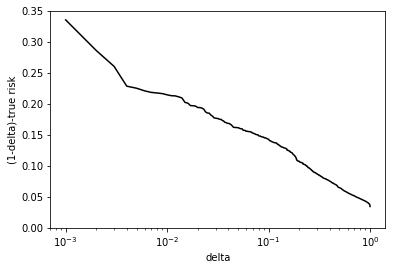

In [43]:
# Figure 1, left
fig, ax = plt.subplots()
ax.semilogx(1-cdf,r_errs,'-k')
plt.xlabel('delta')
plt.ylabel('(1-delta)-true risk')
plt.ylim(bottom=0)
plt.xlim(left=0)
# plt.savefig('truerisk.pdf')
plt.show()

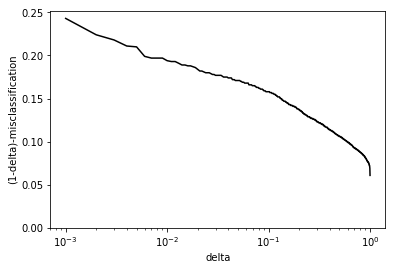

In [44]:
# Figure 1, right
fig, ax = plt.subplots()
ax.semilogx(1-cdf,c_errs,'-k')
plt.xlabel('delta')
plt.ylabel('(1-delta)-misclassification')
plt.ylim(bottom=0)
plt.xlim(left=0)
# plt.savefig('misclassification.pdf')
plt.show()